In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('paper')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.io import load_events, load_pds, load_lcurve
from hendrics.efsearch import folding_search, z_n_search
from hendrics.phaseogram import InteractivePhaseogram
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from scipy.optimize import curve_fit

from stingray.utils import rebin_data
from stingray import Lightcurve, Crossspectrum
from stingray.simulator import simulator
from scipy.ndimage.filters import gaussian_filter1d
import stingray.pulse.pulsar as plsr
from stingray.pulse.search import search_best_peaks
from stingray.gti import time_intervals_from_gtis
from hendrics.efsearch import dyn_folding_search, z_n_search

import astropy.constants as const
#from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import models, fitting


Tecl0_Falanga = -202980486.816
Tecl001 = 79052598.706
Tecl003 = 81742610.371
Porb0_Falanga = 3.891923160*24.0*3600.0
Porbdot_Falanga = (-3.541E-6/365.0) * Porb0_Falanga/(24.0*3600.0)
w_Inam = 166.0
a_Falanga = 27.9
i_Falanga = 62.0
e_Inam = 0.00089
x_Inam = 53.4876


def gauss(x, a, b, c):
    pdf =  a*np.exp(np.square(x-b)/((-2.0)*np.square(c)))
    return pdf
    
def orbitalcorrect(times, Tecl, Porb, Porbdot, w, e, a, i):
    T90 = Tecl + e*Porb*np.cos(np.radians(w))/np.pi
    Porb += Porbdot*(times[0] + times[-1] - 2.0*Tecl)/2.0
    l = np.divide(np.multiply(np.subtract(times, T90),2.0*np.pi),Porb) + np.pi/2.0
    x = const.R_sun*a*np.sin(np.radians(i))/const.c
    return (times - (x*np.sin(l) - x*e*(3.0*np.sin(np.radians(w)) - np.cos(np.radians(w))*np.sin(2.0*l) + np.sin(np.radians(w))*np.cos(2.0*l))/2.0).value)
    #return (times +  (x*np.sin(l)).value)

def orbitalcorrect_gti(gti, Tecl, Porb, Porbdot, w, e, a, i):
    start = orbitalcorrect(gti.T[0], Tecl, Porb, Porbdot, w, e, a, i)
    end = orbitalcorrect(gti.T[1], Tecl, Porb, Porbdot, w, e, a, i)
    result = np.array([start,end]).T
    return result
    

# Preprocessing for Lightcurves

In [2]:
!HENreadevents nu*.evt --noclobber

In [3]:
!HENcalibrate *_ev.nc

In [6]:
!HENlcurve -e 3 79 *_ev_calib.nc -b 10.0


# Obsid 001 Lightcurve

<IPython.core.display.Javascript object>


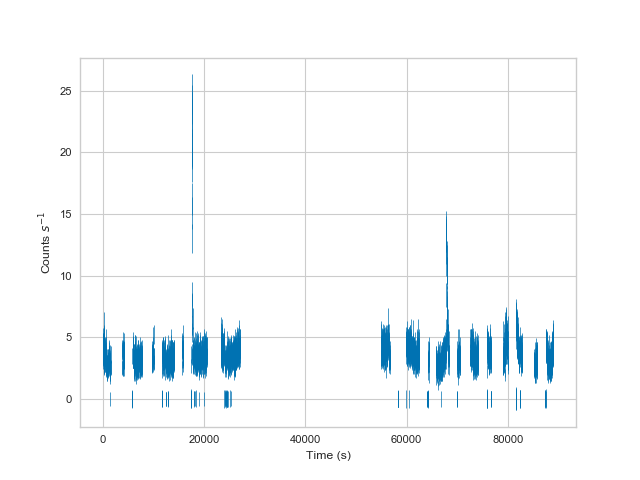

In [7]:
lcurve = load_lcurve('nu10002013001A01_cl_barycorr_nustar_fpma_E3-79_lc.nc')
plt.figure()
plt.errorbar(np.subtract(lcurve.time,lcurve.gti[0,0]), lcurve.countrate, yerr=lcurve.countrate_err, fmt='none', lw=0.5)
plt.ylabel('Counts ' + r'$s^{-1}$')
plt.xlabel('Time (s)')

In [7]:
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001A01_filt_nustar_fpma_E3-79_lc.eps')
#plt.close()

# Obsid 003 Lightcurve

<IPython.core.display.Javascript object>


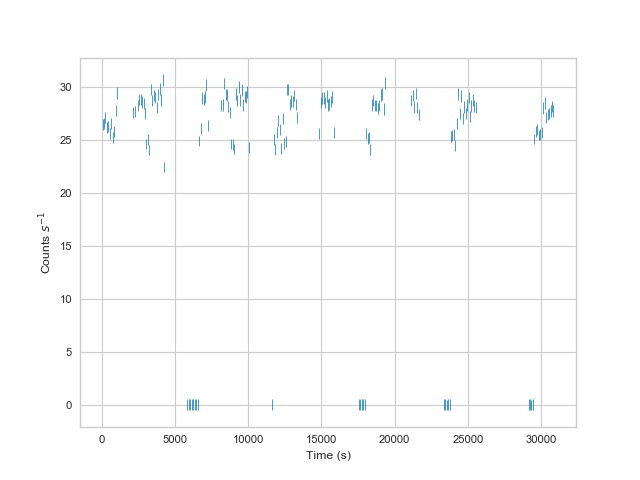

In [8]:
lcurve = load_lcurve('nu10002013003A01_cl_barycorr_nustar_fpma_E3-79_lc.nc')
plt.figure()
plt.errorbar(np.subtract(lcurve.time,lcurve.gti[0,0]), lcurve.countrate, yerr=lcurve.countrate_err, fmt='none', lw=0.5)
plt.ylabel('Counts ' + r'$s^{-1}$')
plt.xlabel('Time (s)')

In [9]:
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013003A01_filt_nustar_fpma_E3-79_lc.eps')
#plt.close()

# Preprocessing for Timing

In [10]:
!HENlcurve -e 3 79 *_ev_calib.nc -b 0.05

In [11]:
#!HENfspec *_lc.nc

# Obsid 003

[[ 81916163.0  81917300.0]
 [ 81918261.0  81918516.0]
 [ 81918518.0  81920469.0]
 [ 81920470.0  81920470.0]
 [ 81920470.0  81920470.0]
 [ 81920470.0  81920474.0]
 [ 81920474.0  81920475.0]
 [ 81920475.0  81920476.0]
 [ 81921917.0  81921918.0]
 [ 81921919.0  81921919.0]
 [ 81921923.0  81921923.0]
 [ 81921924.0  81923479.0]
 [ 81924259.0  81926288.0]
 [ 81927737.0  81927737.0]
 [ 81927738.0  81929597.0]
 [ 81930917.0  81932091.0]
 [ 81932091.0  81932091.0]
 [ 81932101.0  81932102.0]
 [ 81933555.0  81933555.0]
 [ 81933557.0  81933557.0]
 [ 81933559.0  81933620.0]
 [ 81933620.0  81935654.0]
 [ 81937214.0  81937924.0]
 [ 81937924.0  81937925.0]
 [ 81937925.0  81937925.0]
 [ 81937927.0  81937927.0]
 [ 81939385.0  81939386.0]
 [ 81939386.0  81939387.0]
 [ 81939387.0  81941831.0]
 [ 81945207.0  81945208.0]
 [ 81945208.0  81945208.0]
 [ 81945210.0  81945212.0]
 [ 81945212.0  81945212.0]
 [ 81945213.0  81947058.0]]


<IPython.core.display.Javascript object>


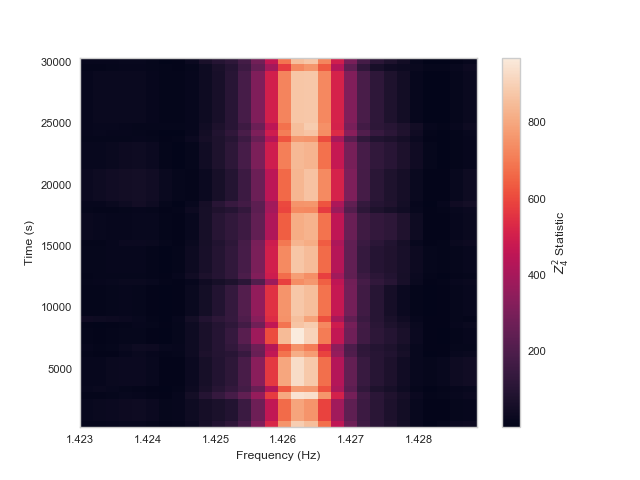

In [12]:
events = load_events('nu10002013003A01_cl_barycorr_nustar_fpma_ev_calib.nc')
events.join(load_events('nu10002013003B01_cl_barycorr_nustar_fpmb_ev_calib.nc'))


events.time = orbitalcorrect(events.time, Tecl003, Porb0_Falanga + Porbdot_Falanga*(Tecl003-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)
events.gti = orbitalcorrect_gti(events.gti, Tecl003, Porb0_Falanga + Porbdot_Falanga*(Tecl003-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)
print(events.gti)
times, frequencies, stats = dyn_folding_search(events, 1.423, 1.429, time_step=512, oversample=10, func=z_n_search)

plt.figure()
plt.pcolormesh(frequencies, times - events.gti[0, 0], stats)
plt.ylabel('Time (s)')
plt.xlabel('Frequency (Hz)')

clrbar = plt.colorbar()
clrbar.set_label(r'$Z^{2}_{4}$' + ' Statistic')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013003_filt_nustar_E3-79_freq_search.eps')

<IPython.core.display.Javascript object>


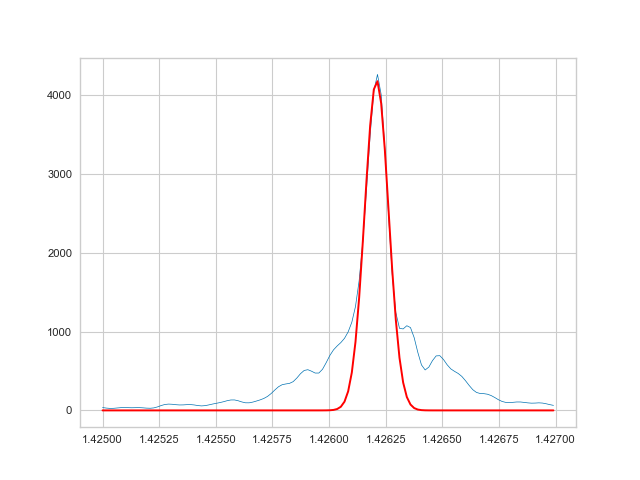

[  4.18859715e+03   1.42620999e+00   5.26410385e-05]
[  4.63666191e+03   1.04981549e-12   1.73275080e-12]


In [13]:
results = \
    folding_search(events, 1.425, 1.427, func=z_n_search)

ff, stats, step, length = results
plt.figure()
plt.plot(ff, stats, lw=0.5)

fpopt, fpcov = curve_fit(gauss, ff[70:80], stats[70:80], p0 = [3000,1.4262, 0.00015])
print(fpopt)
print(np.diag(fpcov))

plt.plot(ff, np.vectorize(gauss)(ff, *fpopt), color = 'r')

Searching 1 frequencies and 58 fdots


<IPython.core.display.Javascript object>


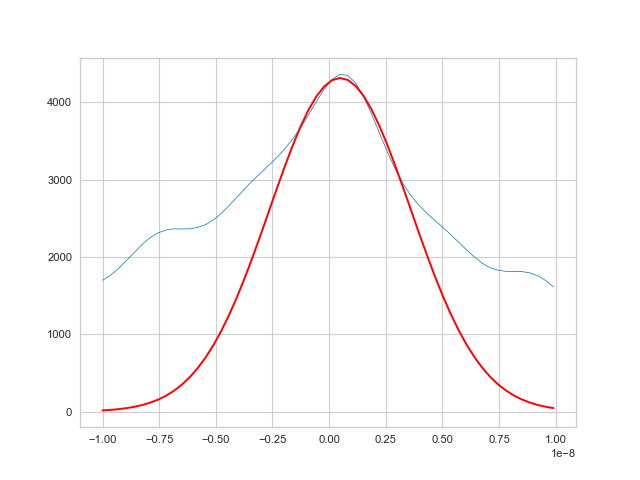

[  4.31411517e+03   4.89173620e-10   3.11338512e-09]
[  4.63666191e+03   1.04981549e-12   1.73275080e-12]


In [14]:
ff, fd, stats, step, fdotsteps, length = folding_search(events, fpopt[1], fpopt[1], step=None, func=z_n_search, oversample=3, fdotmin=-1e-08, fdotmax=1e-08)
fd = fd.flatten()
stats = stats.flatten()
plt.figure()
plt.plot(fd, stats, lw = 0.5)
fdpopt, fdpcov = curve_fit(gauss, fd[24:35], stats[24:35], p0 = [3000, 5e-10, 4e-9])
print(fdpopt)
print(np.diag(fpcov))

plt.plot(fd, np.vectorize(gauss)(fd, *fdpopt), color = 'r')


In [15]:
results = folding_search(events, 1.4255, 1.427, step=None, func=z_n_search, oversample=3, fdotmin=-1e-08, fdotmax=1e-08)

ff, fd, stats, step, fdotsteps, length = results
print("Done")
print(fd)

Searching 140 frequencies and 58 fdots
Done
[[ -1.00000000e-08  -1.00000000e-08  -1.00000000e-08 ...,  -1.00000000e-08
   -1.00000000e-08  -1.00000000e-08]
 [ -9.65078953e-09  -9.65078953e-09  -9.65078953e-09 ...,  -9.65078953e-09
   -9.65078953e-09  -9.65078953e-09]
 [ -9.30157907e-09  -9.30157907e-09  -9.30157907e-09 ...,  -9.30157907e-09
   -9.30157907e-09  -9.30157907e-09]
 ..., 
 [  9.20657558e-09   9.20657558e-09   9.20657558e-09 ...,   9.20657558e-09
    9.20657558e-09   9.20657558e-09]
 [  9.55578605e-09   9.55578605e-09   9.55578605e-09 ...,   9.55578605e-09
    9.55578605e-09   9.55578605e-09]
 [  9.90499651e-09   9.90499651e-09   9.90499651e-09 ...,   9.90499651e-09
    9.90499651e-09   9.90499651e-09]]


<IPython.core.display.Javascript object>


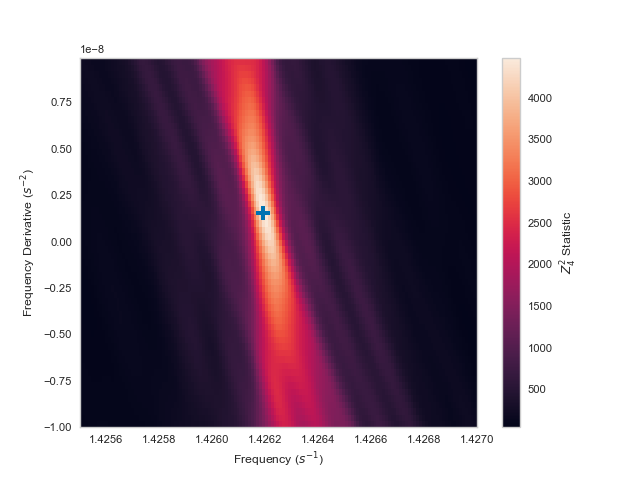

In [16]:
p_init = models.Gaussian2D(amplitude = 3000, x_mean = fpopt[1], y_mean = fdpopt[1], x_stddev=fpopt[2], y_stddev=fdpopt[2])
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, ff, fd, stats)
plt.figure()
plt.pcolormesh(ff, fd, stats)
#CS = plt.contour(ff, fd, p(ff, fd), 3, linewidths = 0.7, colors = 'w')
#print(CS.levels/p.amplitude)
xmax, ymax = np.unravel_index(np.argmax(stats), np.shape(stats))
plt.plot(ff[xmax,ymax], fd[xmax,ymax], marker = 'P', markersize=10)
plt.ylabel('Frequency Derivative (' + r'$s^{-2}$' + ')')
plt.xlabel('Frequency (' + r'$s^{-1}$' + ')')

clrbar = plt.colorbar()
clrbar.set_label(r'$Z^{2}_{4}$' + ' Statistic')
#plt.plot(p.x_mean, p.y_mean, marker = 'P', color = 'w')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013003_filt_nustar_E3-79_pulse_search.eps')

<IPython.core.display.Javascript object>


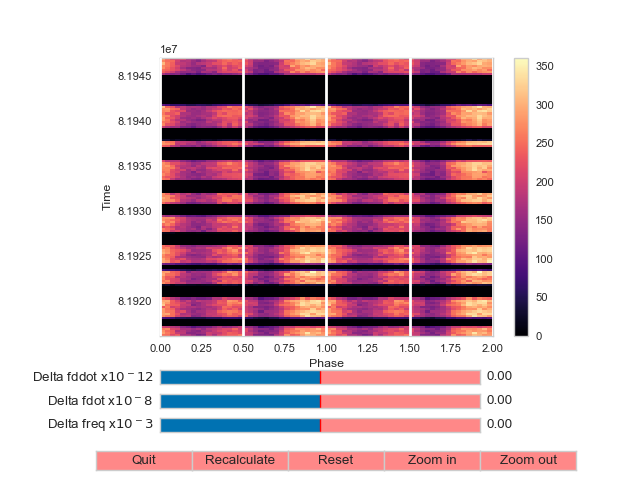

In [17]:
reference_time = events.gti[0,0]
ip = InteractivePhaseogram(events.time, ff[xmax,ymax], fdot = fd[xmax,ymax], nph=32, nt=128, pepoch=reference_time)

In [18]:
freqList=ip.get_values()
print(freqList)

(1.4261904988692469, 1.5239453504202268e-09, 0)


<IPython.core.display.Javascript object>


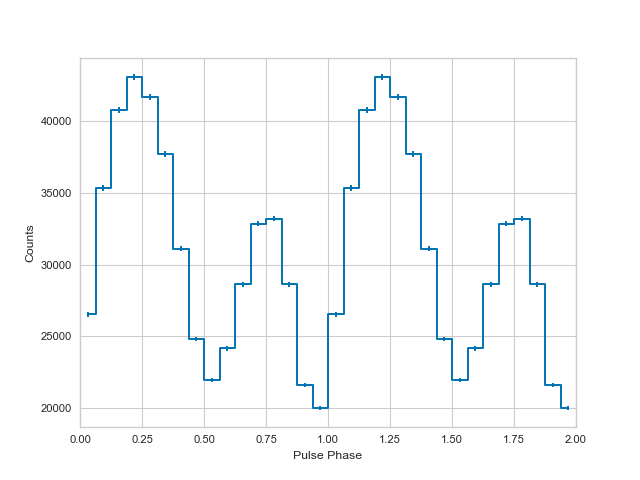

0.536534398291
0.00396841989842


In [19]:
phase_bins, profile, profile_err = plsr.fold_events(events.time, *freqList, bins=16, ref_time = reference_time)
doubleProfile = np.roll(np.concatenate((profile,profile)), 5)
doubleProfile_err = np.roll(np.concatenate((profile_err,profile_err)), 5)
doublePhase_bins = np.concatenate((phase_bins,np.add(phase_bins, 1.0)))
plt.figure()
plt.step(doublePhase_bins, doubleProfile, where = 'mid')
plt.errorbar(doublePhase_bins,doubleProfile, yerr=doubleProfile_err, fmt='none', c=sns.color_palette()[0])
plt.xlim(0.0, 2.0)
#plt.step(np.add(phase_bins, 1.0), profile, where = 'mid', c= sns.color_palette()[0])
#plt.errorbar(np.add(phase_bins, 1.0),profile, yerr=profile_err, fmt='none', c=sns.color_palette()[0])
print((np.max(profile)-np.min(profile))/np.max(profile))
frac_err = (np.min(profile)/np.max(profile))*np.sqrt((1.0/np.max(profile)) + (1.0/np.min(profile)))
print(frac_err)
plt.ylabel('Counts')
plt.xlabel('Pulse Phase')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013003_filt_nustar_E3-79_pulse_profile.eps')

## Binning up 003

In [21]:
events = load_events('nu10002013003A01_cl_barycorr_nustar_fpma_ev_calib.nc')
events.join(load_events('nu10002013003B01_cl_barycorr_nustar_fpmb_ev_calib.nc'))

events.time = orbitalcorrect(events.time, Tecl003, Porb0_Falanga + Porbdot_Falanga*(Tecl003-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)
events.gti = orbitalcorrect_gti(events.gti, Tecl003, Porb0_Falanga + Porbdot_Falanga*(Tecl003-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)


bins = 10
events_filt = [copy.deepcopy(events) for i in range(bins)]
binwidth = (events.gti[-1,-1] - events.gti[0,0])/bins
for i in range(bins):
    events_filt[i].gti = events.gti

    good = np.multiply(events.time > (events_filt[i].gti[0, 0] + binwidth*i), events.time < (events_filt[i].gti[0,0] + binwidth*(i+1)))
    events_filt[i].time = events.time[good]

<IPython.core.display.Javascript object>


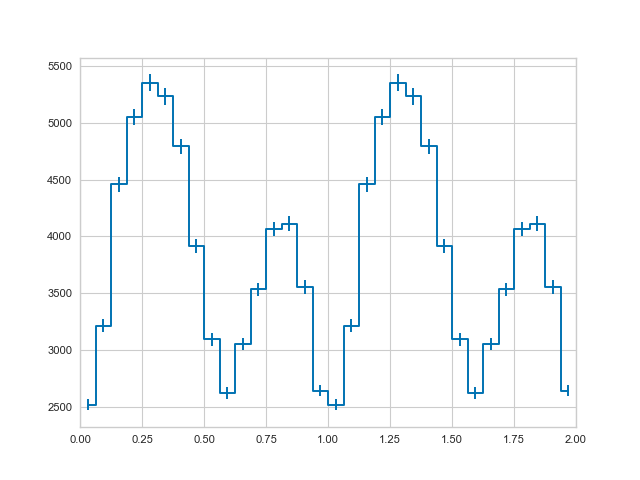

<IPython.core.display.Javascript object>


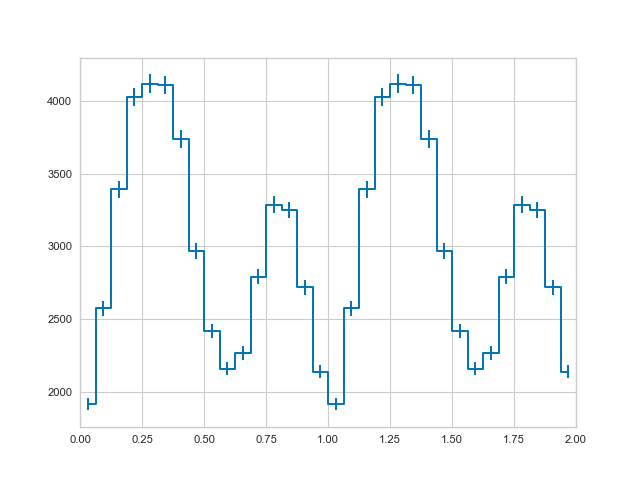

<IPython.core.display.Javascript object>


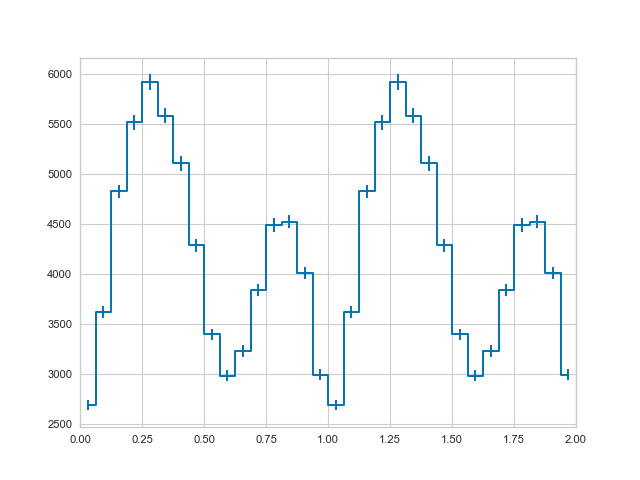

<IPython.core.display.Javascript object>


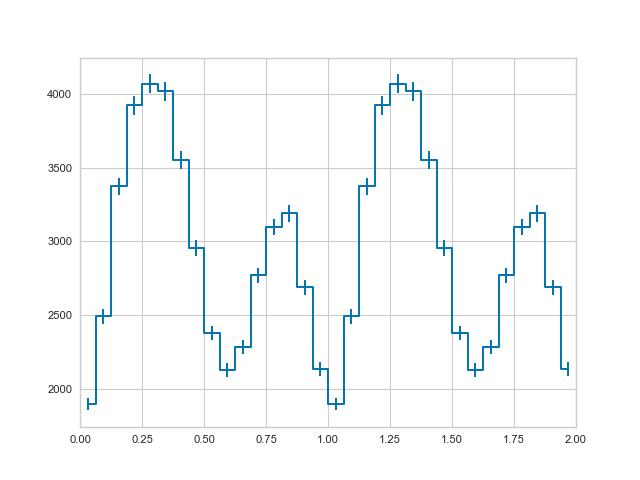

<IPython.core.display.Javascript object>


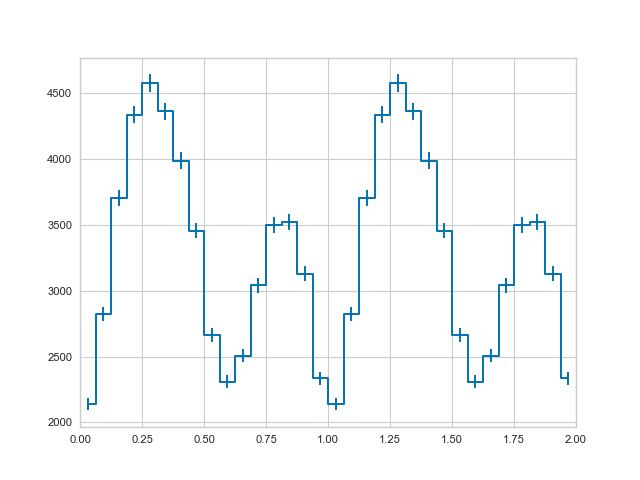

<IPython.core.display.Javascript object>


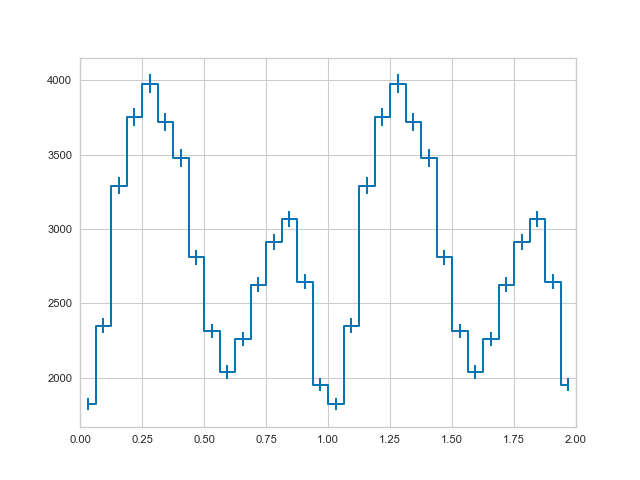

<IPython.core.display.Javascript object>


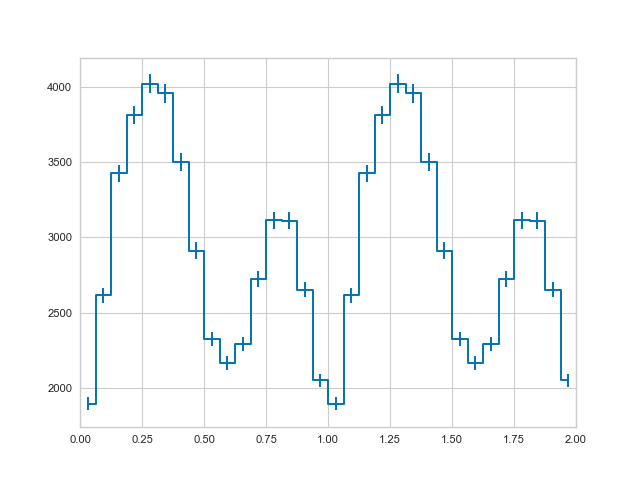

<IPython.core.display.Javascript object>


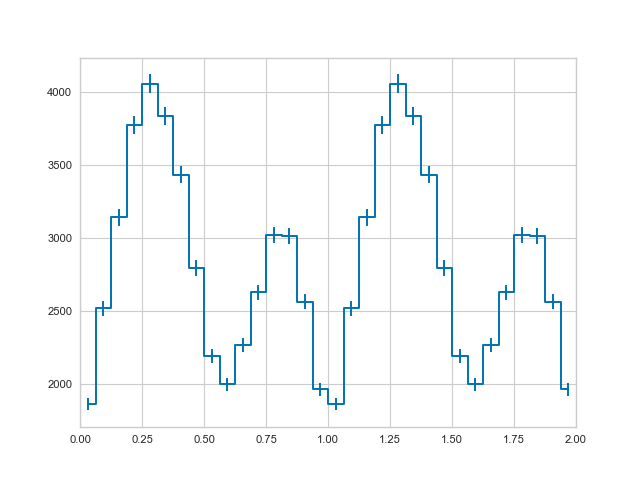

<IPython.core.display.Javascript object>


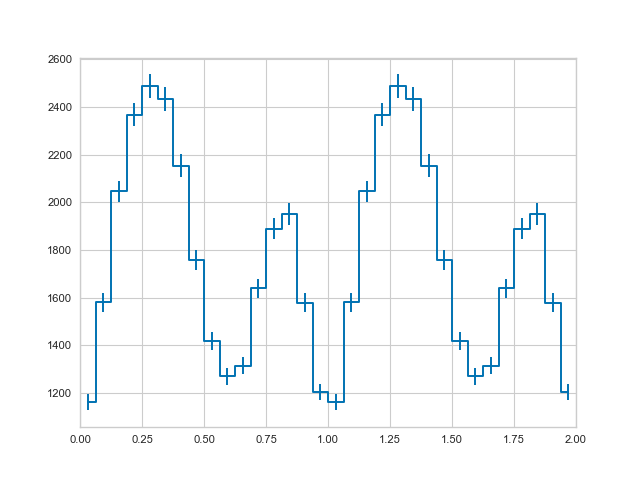

<IPython.core.display.Javascript object>


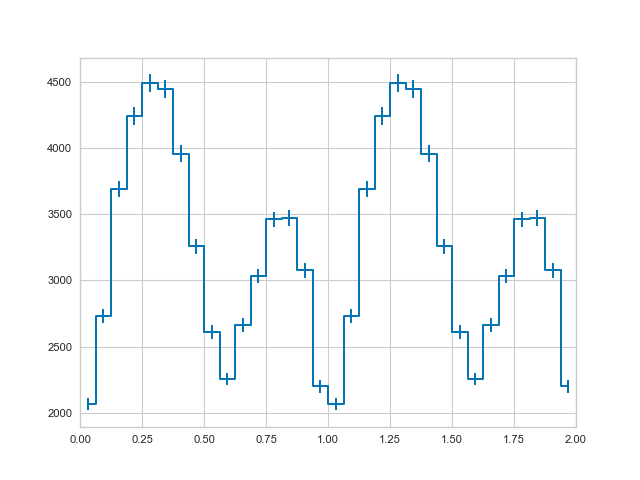

In [22]:
pulse_fractions = []
pulse_fraction_err = []
for i in range(bins):
    phase_bins, profile, profile_err = plsr.fold_events(events_filt[i].time, *freqList, bins=16, ref_time=reference_time)
    doubleProfile = np.roll(np.concatenate((profile,profile)), 6)
    doubleProfile_err = np.roll(np.concatenate((profile_err,profile_err)), 6)
    doublePhase_bins = np.concatenate((phase_bins,np.add(phase_bins, 1.0)))
    plt.figure()
    plt.step(doublePhase_bins, doubleProfile, where = 'mid')
    plt.errorbar(doublePhase_bins,doubleProfile, yerr=doubleProfile_err, fmt='none', c=sns.color_palette()[0])
    plt.xlim(0.0, 2.0)
    pulse_fractions.append((np.max(profile)-np.min(profile))/np.max(profile))

[0.52988419872992154, 0.53496843127731908, 0.54608372721134368, 0.53343166175024581, 0.5331002840288398, 0.54161428212220264, 0.52922158666998265, 0.54045387271830292, 0.53258246178600166, 0.54031180400890866]


<IPython.core.display.Javascript object>


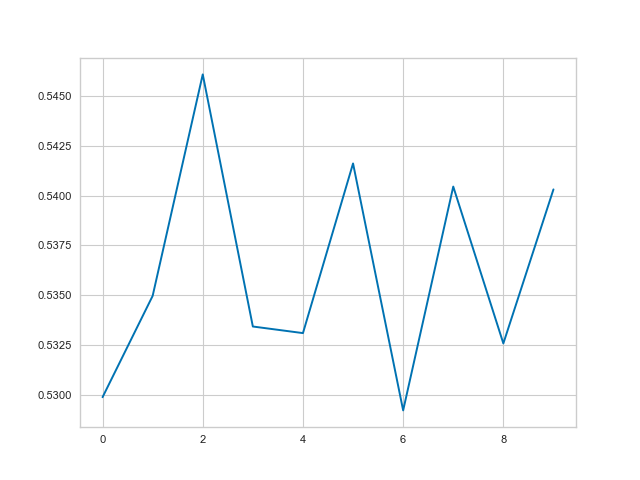

In [23]:
print(pulse_fractions)
plt.figure()
plt.plot(range(bins), pulse_fractions)

# Obsid 001

## Dynamical Z search

<IPython.core.display.Javascript object>


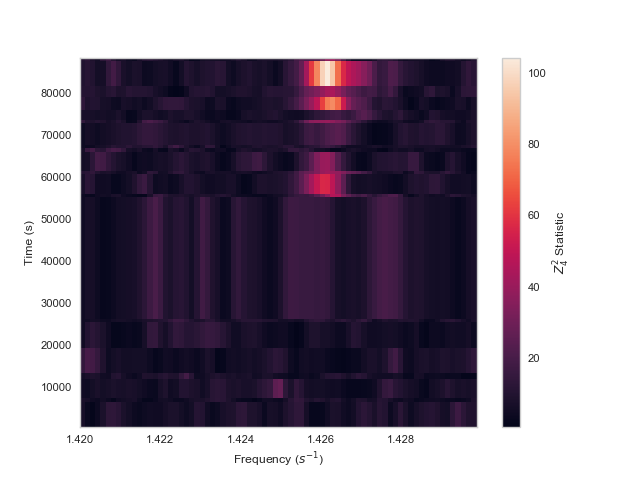

In [24]:
events = load_events('nu10002013001A01_cl_barycorr_nustar_fpma_ev_calib.nc')
events.join(load_events('nu10002013001B01_cl_barycorr_nustar_fpmb_ev_calib.nc'))
events.time = orbitalcorrect(events.time, Tecl001, Porb0_Falanga + Porbdot_Falanga*(Tecl001-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)
events.gti = orbitalcorrect_gti(events.gti, Tecl001, Porb0_Falanga + Porbdot_Falanga*(Tecl001-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)

times, frequencies, stats = dyn_folding_search(events, 1.42, 1.43, time_step=768, oversample=10, func=z_n_search)

plt.figure()
plt.pcolormesh(frequencies, times - events.gti[0, 0], stats)

clrbar = plt.colorbar()
clrbar.set_label(r'$Z^{2}_{4}$' + ' Statistic')
plt.xlabel('Frequency (' + r'$s^{-1}$' + ')')
plt.ylabel('Time (s)')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001_filt_nustar_E3-79_freq_search.eps')

## Second part of observation

In [25]:
good_gti = np.array([g for g in events.gti if (g[0] > 50000 + events.gti[0, 0])])

events_filt = copy.deepcopy(events)
events_filt.gti = good_gti

good = events.time > events_filt.gti[0, 0]
print(good)
events_filt.time = events.time[good]

[False False False ...,  True  True  True]


Simple search over frequency

<IPython.core.display.Javascript object>


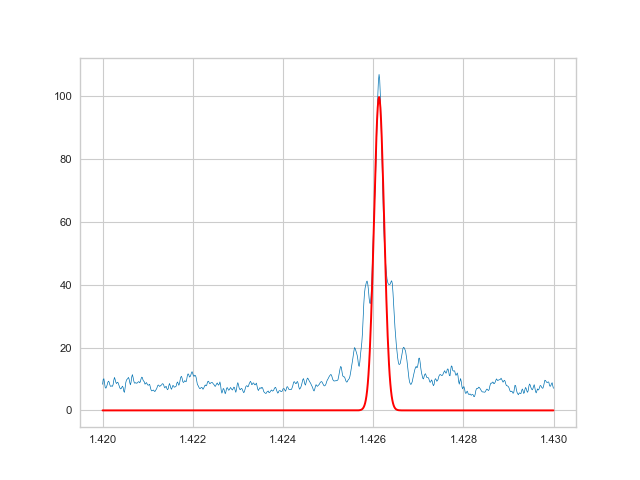

[  9.98248920e+01   1.42612965e+00   1.12643421e-04]
[  5.29042289e+00   1.52969579e-11   2.66401836e-11]


In [26]:
results = \
    folding_search(events_filt, 1.42, 1.43, func=z_n_search)

ff, stats, step, length = results
plt.figure()
plt.plot(ff, stats, lw=0.5)

fpopt, fpcov = curve_fit(gauss, ff[410:430], stats[410:430], p0 = [120,1.4262, 0.00015])
print(fpopt)
print(np.diag(fpcov))

plt.plot(ff, np.vectorize(gauss)(ff, *fpopt), color = 'r')

Searching 1 frequencies and 70 fdots


<IPython.core.display.Javascript object>


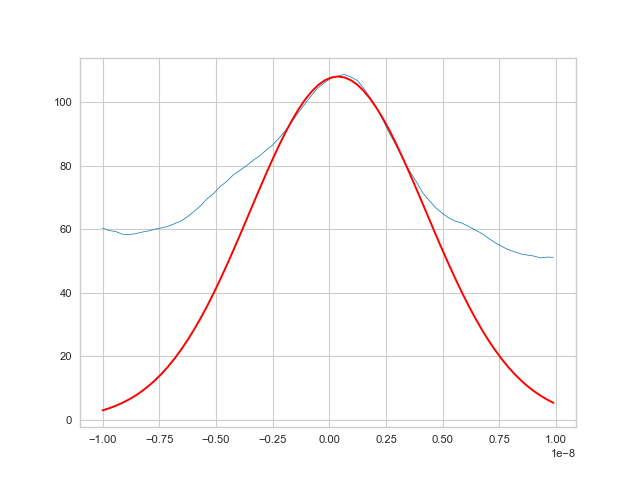

[  1.07977323e+02   3.78654390e-10   3.88351908e-09]
[  5.29042289e+00   1.52969579e-11   2.66401836e-11]


In [27]:
ff, fd, stats, step, fdotsteps, length = folding_search(events_filt, fpopt[1], fpopt[1], step=None, func=z_n_search, oversample=3, fdotmin=-1e-08, fdotmax=1e-08)
fd = fd.flatten()
stats = stats.flatten()
plt.figure()
plt.plot(fd, stats, lw = 0.5)
fdpopt, fdpcov = curve_fit(gauss, fd[27:47], stats[27:47], p0 = [120, 6e-10, 5e-9])
print(fdpopt)
print(np.diag(fpcov))

plt.plot(fd, np.vectorize(gauss)(fd, *fdpopt), color = 'r')


In [28]:
# Over f and fdot
results = \
    folding_search(events_filt, 1.425, 1.427, step=None,
                   func=z_n_search, oversample=3, fdotmin=-1e-8, fdotmax=1e-08)

ff, fd, stats, step, fdotsteps, length = results
print("Done")

Searching 205 frequencies and 70 fdots
Done


<IPython.core.display.Javascript object>


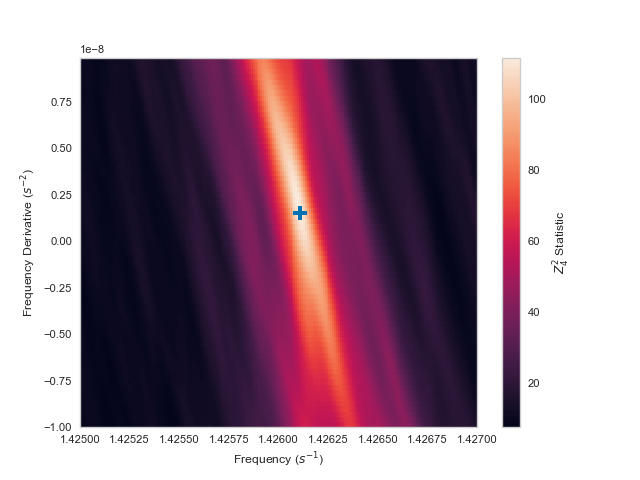

Parameter('x_mean', value=1.4260742317674686)
Parameter('y_mean', value=3.079111508945925e-09)


In [29]:
p_init = models.Gaussian2D(amplitude = 120, x_mean = fpopt[1], y_mean = fdpopt[1], x_stddev=fpopt[2], y_stddev=fdpopt[2])
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, ff, fd, stats)
plt.figure()
plt.pcolormesh(ff, fd, stats)
#CS = plt.contour(ff, fd, p(ff, fd), 3, linewidths = 0.7, colors = 'w')
print(p.x_mean)
print(p.y_mean)
xmax, ymax = np.unravel_index(np.argmax(stats), np.shape(stats))
plt.plot(ff[xmax,ymax], fd[xmax,ymax], marker = 'P', markersize=10)
plt.ylabel('Frequency Derivative (' + r'$s^{-2}$' + ')')
plt.xlabel('Frequency (' + r'$s^{-1}$' + ')')

clrbar = plt.colorbar()
clrbar.set_label(r'$Z^{2}_{4}$' + ' Statistic')
#plt.plot(p.x_mean, p.y_mean, marker = 'P', color = 'w')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001_filt_nustar_E3-79_pulse_search_part2.eps')

Let's interactively adjust f, fdot and fddot

<IPython.core.display.Javascript object>


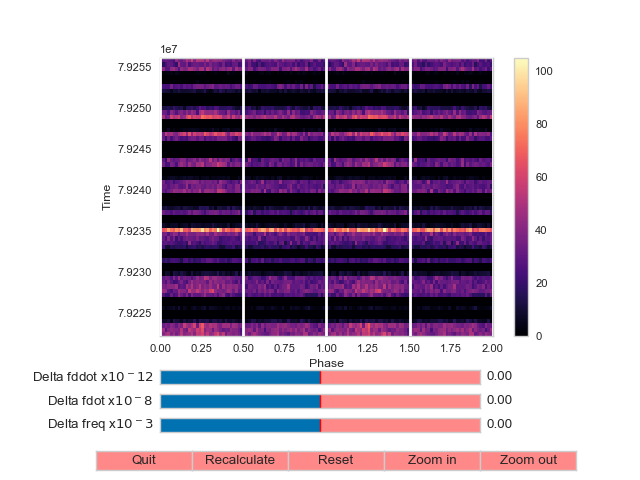

In [30]:
reference_time = events_filt.gti[0,0]
#print(events_filt.gti)
ip = InteractivePhaseogram(events_filt.time, ff[xmax,ymax], nph=64, nt=64, fdot=fd[xmax,ymax], pepoch=reference_time)

... and retrieve the best values

In [31]:
freqList = ip.get_values()
print(freqList)

(1.4261073731511258, 1.5242411701542333e-09, 0)


<IPython.core.display.Javascript object>


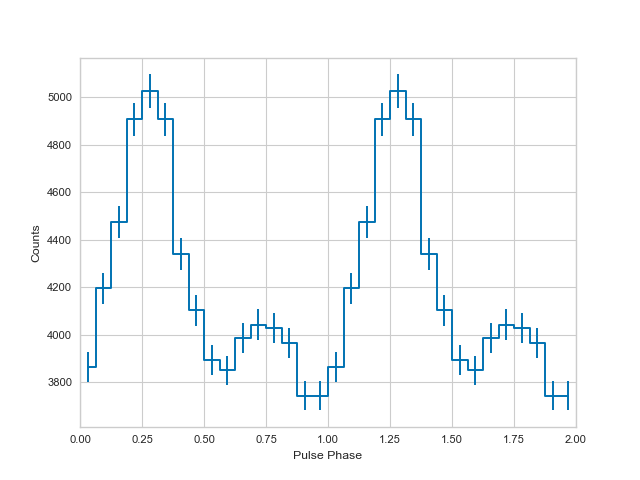

0.255124378109
0.0160825935013


In [32]:
#print(freqList)
phase_bins, profile, profile_err = plsr.fold_events(events_filt.time, *freqList, bins=16, ref_time=reference_time)
doubleProfile = np.roll(np.concatenate((profile,profile)), 0)
doubleProfile_err = np.roll(np.concatenate((profile_err,profile_err)), 0)
doublePhase_bins = np.concatenate((phase_bins,np.add(phase_bins, 1.0)))
plt.figure()
plt.step(doublePhase_bins, doubleProfile, where = 'mid')
plt.errorbar(doublePhase_bins,doubleProfile, yerr=doubleProfile_err, fmt='none', c=sns.color_palette()[0])
plt.xlim(0.0, 2.0)
plt.ylabel('Counts')
plt.xlabel('Pulse Phase')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001_filt_nustar_E3-79_pulse_profile_part2.eps')
print((np.max(profile)-np.min(profile))/np.max(profile))
frac_err = (np.min(profile)/np.max(profile))*np.sqrt((1.0/np.max(profile)) + (1.0/np.min(profile)))
print(frac_err)

## Binning up 001 pulsing epoch

In [33]:
good_gti = np.array([g for g in events.gti if (g[0] > 50000 + events.gti[0, 0])])
bins = 10
events_filt = [copy.deepcopy(events) for i in range(bins)]
binwidth = (good_gti[-1,-1] - good_gti[0,0])/bins
for i in range(bins):
    events_filt[i].gti = good_gti

    good = np.multiply(events.time > (events_filt[i].gti[0, 0] + binwidth*i), events.time < (events_filt[i].gti[0,0] + binwidth*(i+1)))
    print(good)
    events_filt[i].time = events.time[good]

[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ..., False False False]
[False False False ...,  True  True  True]


<IPython.core.display.Javascript object>


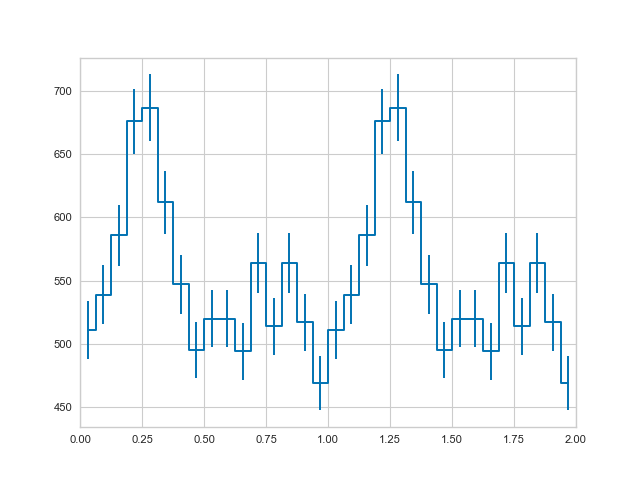

<IPython.core.display.Javascript object>


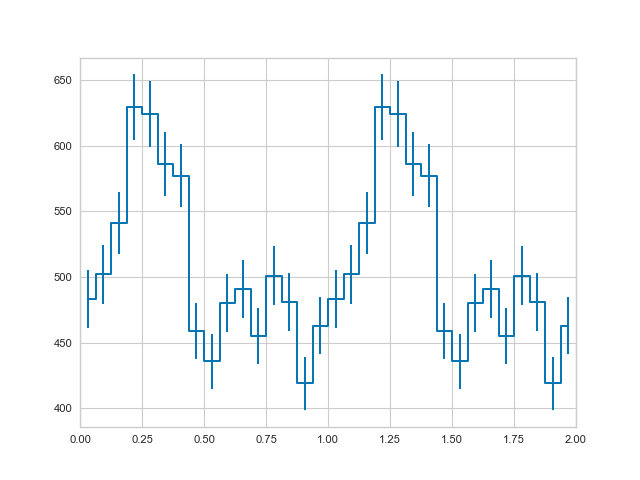

<IPython.core.display.Javascript object>


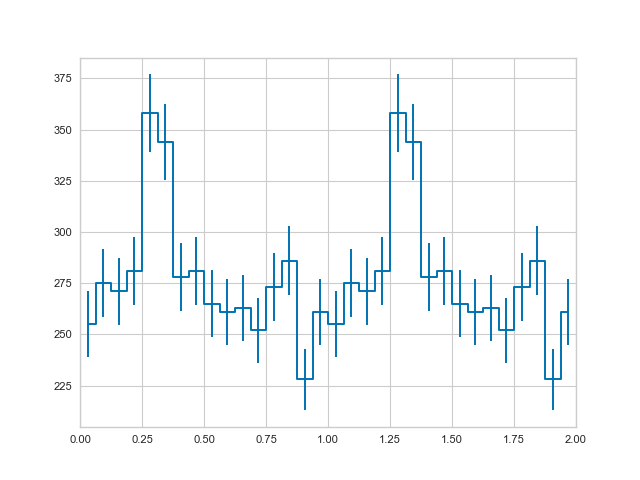

<IPython.core.display.Javascript object>


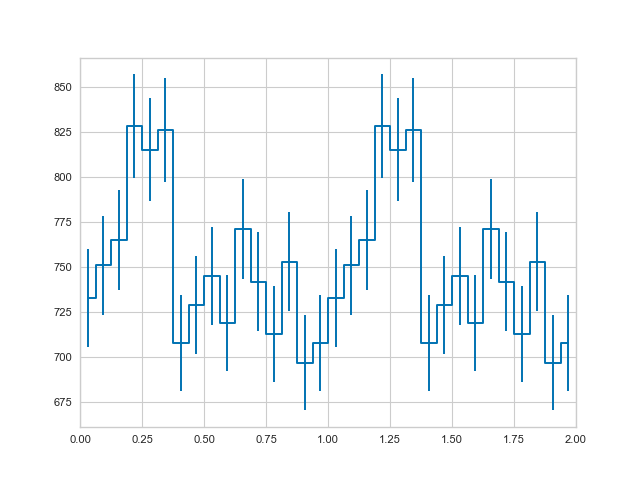

<IPython.core.display.Javascript object>


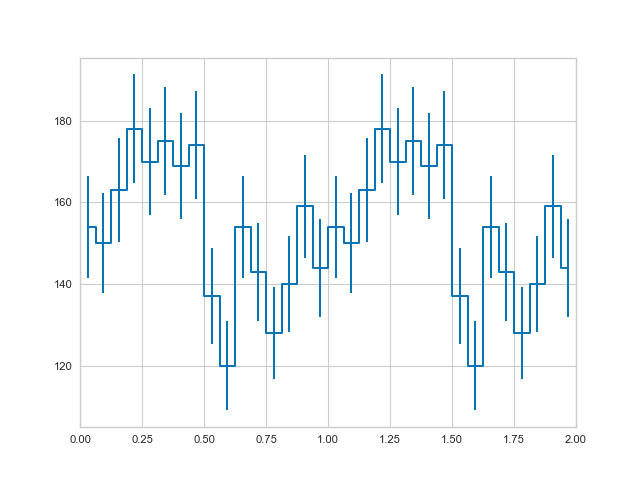

<IPython.core.display.Javascript object>


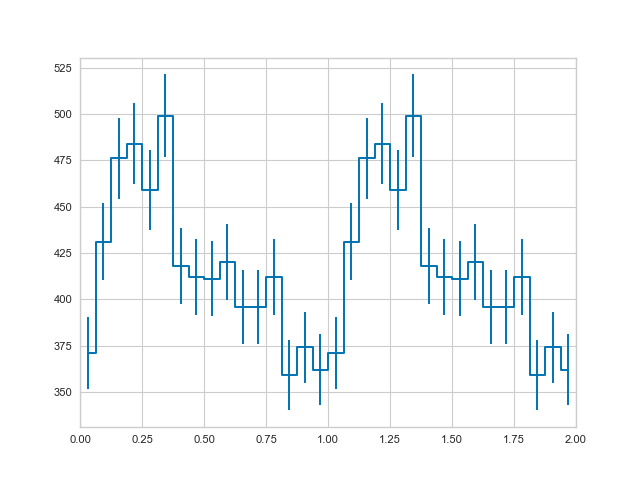

<IPython.core.display.Javascript object>


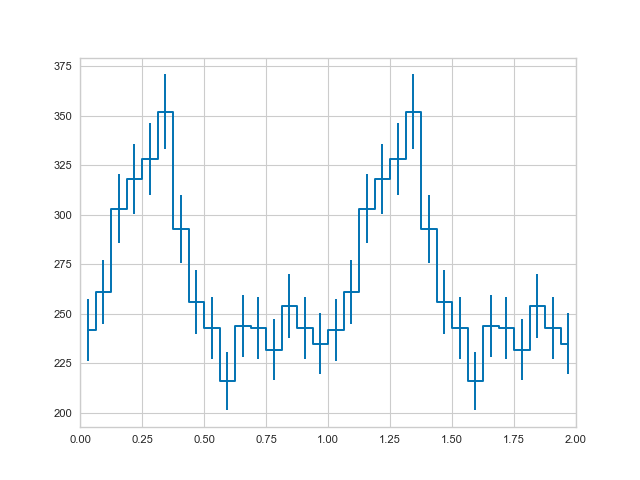

<IPython.core.display.Javascript object>


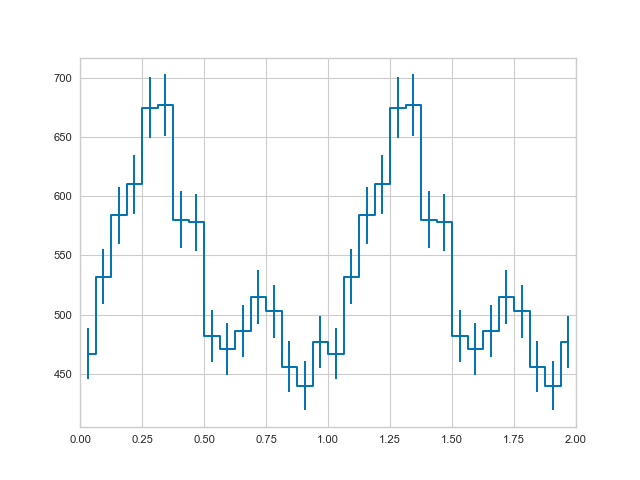

<IPython.core.display.Javascript object>


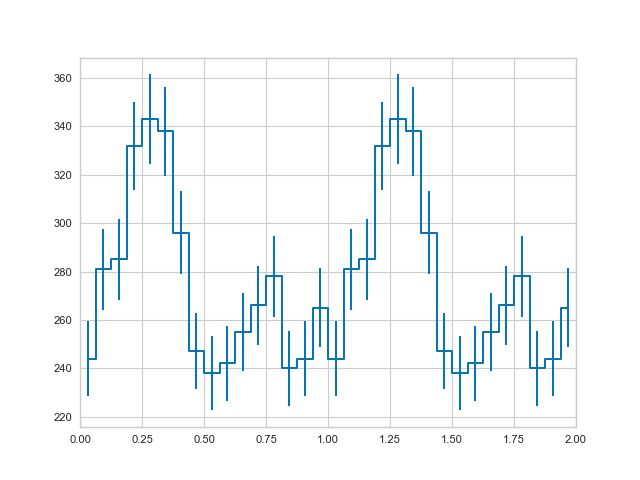

<IPython.core.display.Javascript object>


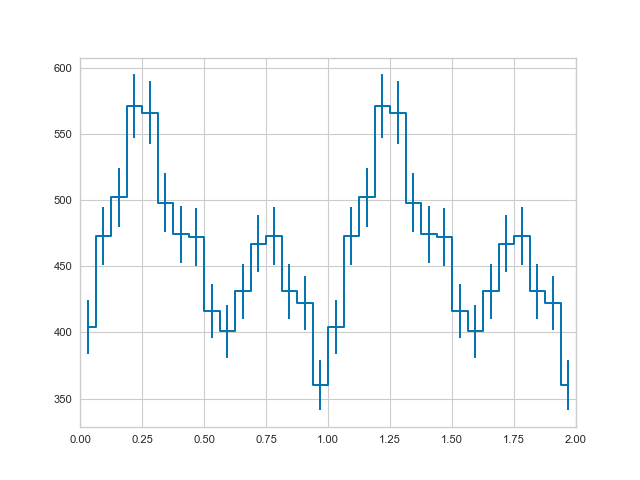

In [34]:
pulse_fractions = []
pulse_fraction_err = []
for i in range(bins):
    phase_bins, profile, profile_err = plsr.fold_events(events_filt[i].time, *freqList, bins=16, ref_time=reference_time)
    doubleProfile = np.concatenate((profile,profile))
    doubleProfile_err = np.concatenate((profile_err,profile_err))
    doublePhase_bins = np.concatenate((phase_bins,np.add(phase_bins, 1.0)))
    plt.figure()
    plt.step(doublePhase_bins, doubleProfile, where = 'mid')
    plt.errorbar(doublePhase_bins,doubleProfile, yerr=doubleProfile_err, fmt='none', c=sns.color_palette()[0])
    plt.xlim(0.0, 2.0)
    pulse_fractions.append((np.max(profile)-np.min(profile))/np.max(profile))
    pulse_fraction_err.append((np.min(profile)/np.max(profile))*np.sqrt((1.0/np.max(profile)) + (1.0/np.min(profile))))

[0.31732168850072778, 0.33386327503974561, 0.36312849162011174, 0.15821256038647344, 0.3258426966292135, 0.28056112224448898, 0.38636363636363635, 0.35007385524372231, 0.30612244897959184, 0.36952714535901926]


<IPython.core.display.Javascript object>


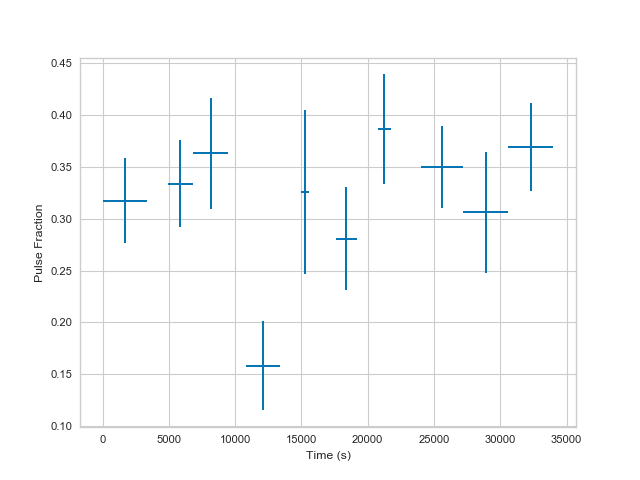

In [35]:
print(pulse_fractions)
plt.figure()
#print(events_filt)
plt.errorbar([(events_filt[i].time[-1] + events_filt[i].time[0])/2.0 for i in range(bins)],\
             pulse_fractions, xerr = [(events_filt[i].time[-1] - events_filt[i].time[0])/2.0 for i in range(bins)],\
             yerr = pulse_fraction_err, fmt = 'none')

plt.ylabel('Pulse Fraction')
plt.xlabel('Time (s)')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001_filt_nustar_E3-79_pulse_fractions_part2.eps')

## First part of observation

In [36]:
events = load_events('nu10002013001A01_cl_barycorr_nustar_fpma_ev_calib.nc')
events.join(load_events('nu10002013001B01_cl_barycorr_nustar_fpmb_ev_calib.nc'))
events.time = orbitalcorrect(events.time, Tecl001, Porb0_Falanga + Porbdot_Falanga*(Tecl001-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)
good_gti = orbitalcorrect_gti(np.array([g for g in events.gti if (g[0] < 30000 + events.gti[0, 0])]), Tecl001, Porb0_Falanga + Porbdot_Falanga*(Tecl001-Tecl0_Falanga), Porbdot_Falanga, w_Inam, e_Inam, a_Falanga, i_Falanga)

events_filt = copy.deepcopy(events)
events_filt.gti = good_gti

good = events.time < events_filt.gti[-1, -1]
events_filt.time = events.time[good]


Searching 98 frequencies and 89 fdots
Done


<IPython.core.display.Javascript object>


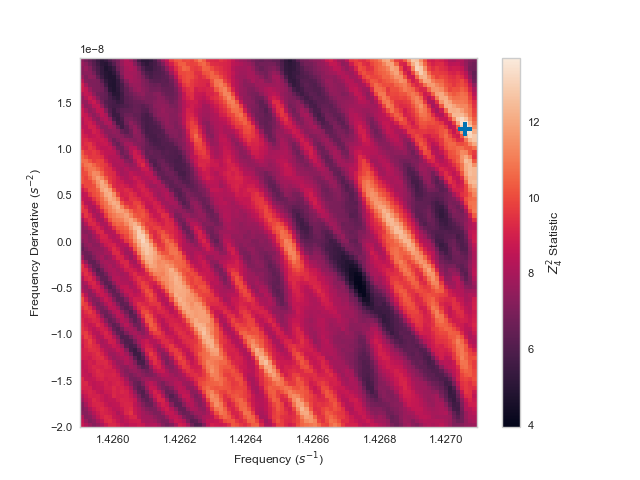

0.0898519677983


In [37]:
# Over f and fdot
results = \
    folding_search(events_filt, 1.4259, 1.4271, step=None,
                   func=z_n_search, oversample=3, fdotmin=-2e-8, fdotmax=2e-8)

ff, fd, stats, step, fdotsteps, length = results
print("Done")
plt.figure()
plt.pcolormesh(ff, fd, stats)
plt.ylabel('Frequency Derivative (' + r'$s^{-2}$' + ')')
plt.xlabel('Frequency (' + r'$s^{-1}$' + ')')

clrbar = plt.colorbar()
clrbar.set_label(r'$Z^{2}_{4}$' + ' Statistic')
xmax, ymax = np.unravel_index(np.argmax(stats), np.shape(stats))
plt.plot(ff[xmax,ymax], fd[xmax,ymax], marker = 'P', markersize = 10)
print(plsr.z2_n_probability(stats[xmax,ymax], n = 4))
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001_filt_nustar_E3-79_pulse_search_part1.eps')

In [38]:
'''results = \
    folding_search(events_filt, 1.42, 1.43, func=z_n_search)

ff, stats, step, length = results
plt.figure()
plt.plot(ff, stats, lw=0.5)
print("Done")'''

'results =     folding_search(events_filt, 1.42, 1.43, func=z_n_search)\n\nff, stats, step, length = results\nplt.figure()\nplt.plot(ff, stats, lw=0.5)\nprint("Done")'

<IPython.core.display.Javascript object>


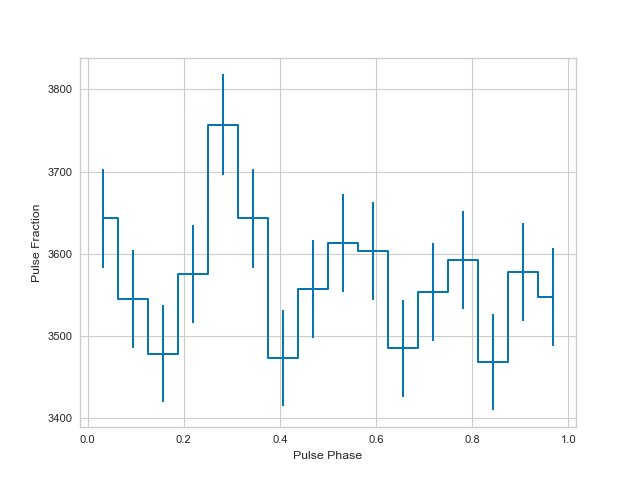

0.0769230769231
0.0217368534577


In [39]:
#print(freqList)
phase_bins, profile, profile_err = plsr.fold_events(events_filt.time, ff[xmax,ymax], fd[xmax,ymax], ref_time=reference_time)
#print(phase_bins)
#print(profile_err)
plt.figure()
plt.step(phase_bins, profile, where = 'mid')
plt.errorbar(phase_bins,profile, yerr=profile_err, fmt='none', c=sns.color_palette()[0])
print((np.max(profile)-np.min(profile))/np.max(profile))
print((np.min(profile)/np.max(profile))*np.sqrt((1.0/np.max(profile)) + (1.0/np.min(profile))))
plt.xlabel('Pulse Phase')
plt.ylabel('Pulse Fraction')
#plt.savefig('/Users/sean/Desktop/SMC_X-1/letter/figures/nu10002013001_filt_nustar_E3-79_pulse_profile_part1.eps')